In this notebook, using two different examples, the Auto Regressive Cepstral Coefficients and Real Cepstral Coefficients **are compared** regarding their discriminatory power in grasping the inner patterns of time series.  
In terms of reliable examinations, similar time windows are found using `stumpy` package. The package is prominent in time series pattern matching domain and can be reffered as a reference. After finding the similar time windows using `stumpy`, I examine the eligibility of cepstral coefficients regarding their ability to discern the underlying patterns of time series. The procedure is as follows:  
1. Find similar pair of time windows using `stumpy`
2. Calculate the cepstral coefficients of two similar time windows (cc1 and cc2) and an unsimilar one (cc3).
3. Calculate the Euclidean distance between each pair of calculated cepstral coefficients (i.e., Euclidean distance between (cc1 and cc3), (cc2, cc3), and (cc1, cc2). Presuming the valid efficiency of cepstral coefficients, I expect $euclidean(cc1, cc2)<euclidean(cc2, cc3)$ and $euclidean(cc1, cc2)<euclidean(cc1, cc3)$).

Two different methods for calculating cepstral coefficients are provided here
- Auto Regressive Cepstral Coefficients (ARCepstral)
- Real Cepstral Coefficients

# ARCepstral
The cepstrum of an ARIMA time–series can be estimated using the parameters of an ARIMA model for that time–series. Consider a time–series $X_t$ defined by an $AR(p)$ model $X_t+\alpha_1X_{t-1}+\ldots+\alpha_pX_{t-p}=\epsilon_t$ where $\alpha_1+\ldots+\alpha_p$ are the auto-regression coefficients and $\epsilon_t$ is white noise with mean 0 and certain non zero variance. Note that for every ARIMA model there exists an equivalent AR model, that can be obtained from the ARIMA model by polynomial division. Hence, without loss of generality, for the remainder of this paper we focus on AR time–series.  
The cepstral coefficients for an $AR(p)$ time–series can be derived from the auto-regression coefficients [[1](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=S.+Furui.+Digital+Speech+Processing%2C+Synthesis%2C+and+Recognition.+Marcel+Deckker%2C+Inc.%2C+New+York%2C+1989.&btnG=)]:
$$
{c_n} = \left\{ {\begin{array}{*{20}{c}}
  { - {\alpha _1},}&{{\text{if n = 1}}} \\ 
  { - {\alpha _n} - \sum\nolimits_{m = 1}^{n - 1} {\left( {1 - \frac{m}{n}} \right){\alpha _m}{c_{n - m}},} }&{{\text{if }}1 < n \leqslant p} \\ 
  { - \sum\nolimits_{m = 1}^p {\left( {1 - \frac{m}{n}} \right){\alpha _m}{c_{n - m}},} }&{{\text{if }}p < n} 
\end{array}} \right.
$$

# Real Cepstral
The real cepstrum is defined as the inverse Fourier transform of the real logarithm of the Fourier transform of the time series [[2](https://doi.org/10.1016/j.eswa.2020.113705
)]. 


# Import the required packages

In [1]:
using PythonCall
using YFinance
stumpy = pyimport("stumpy")
np = pyimport("numpy")
include("../src/CepstralClustering.jl")
using .CepstralClustering
import PythonPlot as plt

# Find similar Time windows using `stumpy`
The daily adjusted close price of the Intel Corporation from 19th, October 2018 to 17th, March 2020 are fetched using the `YFinance.jl` package. The time series passed to the `stumpy` package in order to find pairs of similar time windows.

In [2]:
series = get_prices("INTC", startdt="2018-10-19", enddt="2020-03-17")["adjclose"];
prof = stumpy.stump(series, 100)
p = pyconvert(Array, prof);

# 1st example

In [3]:
motif_idx = sortperm(p[:, 1])[100]
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])
@info pair

[ Info: 250
[ Info: 42


According to the result of the cell above, the 250th window is similar with the 42th window. 

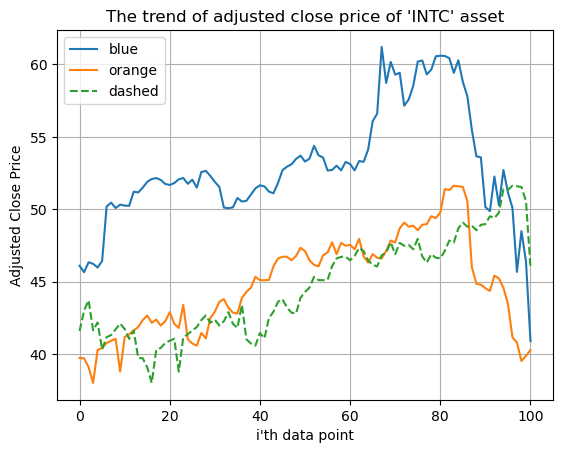

In [9]:
plt.plot(series[250:250+100], label="blue")
plt.plot(series[42:42+100], label="orange")
plt.plot(series[29:29+100], linestyle="--", label="dashed")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

As can be seen from the figure above, the blue and the orange series share common patterns in this frame. Thus, it is expected to see the minimum cepstral distance between these two series compared with other possible pairs (i.e., the dashed line and the blue line). 

## ARCepstral

In [5]:
cc1 = cc(ARCepstral, series[250:250+100], 1, 5)
cc2 = cc(ARCepstral, series[42:42+100], 1, 5)
cc3 = cc(ARCepstral, series[29:29+100], 1, 5)
euc(v1, v2) = (v1.-v2).^2 |> sum |> sqrt
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

[ Info: 0.023242246028682943
[ Info: 0.026539238724186086
[ Info: 0.0032971172704045855


The results indicate that the orange and the dashed series share similar patterns with each other. According to the figure above, the blue and orange series share a more similar pattern. Thus, the results do not verify the expected outcome.

## Real Cepstral

In [106]:
cc1 = cc(RealCepstral, series[250:250+100], 5, 5)
cc2 = cc(RealCepstral, series[42:42+100], 5, 5)
cc3 = cc(RealCepstral, series[29:29+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

[ Info: 0.10794004625165242
[ Info: 0.3607796202821378
[ Info: 0.38478378343114067


The results approve that the blue and orange series share the most similar patterns compared with the other pairs (i.e., the orange and dashed series). The result can be testified by the visualization above.

# 2nd example

In [6]:
motif_idx = sortperm(p[:, 1])[75]
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])
@info pair

[ Info: 228
[ Info: 28


According to the result of the above cell, the 228th window is similar with the 28th window. 

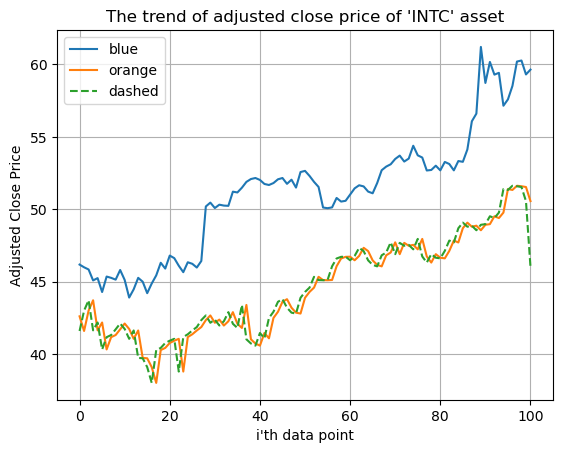

In [7]:
import PythonPlot as pl
plt.plot(series[motif_idx:motif_idx+100], label="blue")
plt.plot(series[pair:pair+100], label="orange")
plt.plot(series[29:29+100], linestyle="--", label="dashed")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

As can be seen from the figure above, the red and green lines are somewhat mirroring each other. Thus, expectedly, their cepstral coefficients must have a lower distance with each other compared to the distance from the cepstral coefficients of the blue line.

## ARCepstral

In [8]:
cc1 = cc(ARCepstral, series[29:29+100], 1, 5)
cc2 = cc(ARCepstral, series[pair:pair+100], 1, 5)
cc3 = cc(ARCepstral, series[motif_idx:motif_idx+100], 1, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

[ Info: 0.053452482356044134
[ Info: 0.06631161969171687
[ Info: 0.0128617162924297


The results indicate that the orange and blue series should share the most similar patterns with each other than other pairs. This cannot be verified, according to the visualized series (provided in three cells earlier). Thus, this case, I can claim that AR cepstracls coefficients are not successful in identifying the inherent patterns of the time series.

## RealCepstral

In [130]:
cc1 = cc(RealCepstral, series[29:29+100], 5, 5)
cc2 = cc(RealCepstral, series[pair:pair+100], 5, 5)
cc3 = cc(RealCepstral, series[motif_idx:motif_idx+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

[ Info: 0.1802611563487017
[ Info: 0.38730622492319106
[ Info: 0.5386602040233419


In terms of using the real cepstral coefficients, the results are in accordance with the visualized figure, and the dashed series and the orange series share the most similar pattern in this comparison. This can be verified by the visualization above.

# Conclusion
According to the results, the Real Cepstral method performs better than AR Cepstral method in presenting the inner patterns of time series through several coefficients.